In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 26,  
    'text.color': 'black', 
    'xtick.labelsize': 26,  
    'ytick.labelsize': 26,  
    'legend.fontsize': 26,  
    'axes.labelsize': 26,  
})

In [2]:
#Parameters
HEIGHT = 200  # pixels per column
WIDTH = 200   # total columns
TAU = 5.0     # time constant tau
DT = .3       # time step in minutes
N_STEPS = HEIGHT 

PHASES = ['ACCH2O', 'ACC', 'CCHH', 'MHC', 'Aragonite']
phase_colors = np.array([
    [1.0, 0.0, 0.0],   
    [0.0, 1.0, 0.0],  
    [0.0, 1.0, 1.0],   
    [1.0, 0.0, 1.0],   
    [0.0, 0.0, 1.0],
], dtype=float)
n_phases = len(PHASES)

init_probs = np.array([0.02, 0.04, 0.08, 0.02, 0.82], dtype=float)
init_probs /= init_probs.sum()

rng = np.random.default_rng(42)


def sample_column():
    """Return one column of randomly assigned phase indices."""
    return rng.choice(n_phases, size=HEIGHT, p=init_probs)

def decay_column(col):
    """Simulate decay of non-aragonite pixels for one time step."""
    new_col = col.copy()
    p_convert = 1.0 - np.exp(-DT / TAU)
    mask = new_col != 4  
    # Bernoulli trial
    convert_mask = rng.random(HEIGHT) < p_convert
    new_col[mask & convert_mask] = 4
    return new_col

#Simulation Loop
columns = [sample_column()]
contrib = np.zeros((n_phases, HEIGHT, WIDTH, 3), dtype=float)

for step in range(N_STEPS):
    # 1. Decay all existing columns
    for c in range(len(columns)):
        columns[c] = decay_column(columns[c])
    
    # 2. sum proportions
    for x, col in enumerate(columns):
        for y in range(HEIGHT):
            ph = col[y]
            contrib[ph, y, x, :] += phase_colors[ph]
    
    # 3. Add a new column if width != N_steps
    if len(columns) < WIDTH:
        columns.append(sample_column())

#final image to be plotted
final_phase = np.zeros((HEIGHT, WIDTH), dtype=int)
for y in range(HEIGHT):
    for x in range(WIDTH):
        strengths = [np.linalg.norm(contrib[p, y, x, :]) for p in range(n_phases)]
        final_phase[y, x] = np.argmax(strengths)

#RGB image
final_image = phase_colors[final_phase]

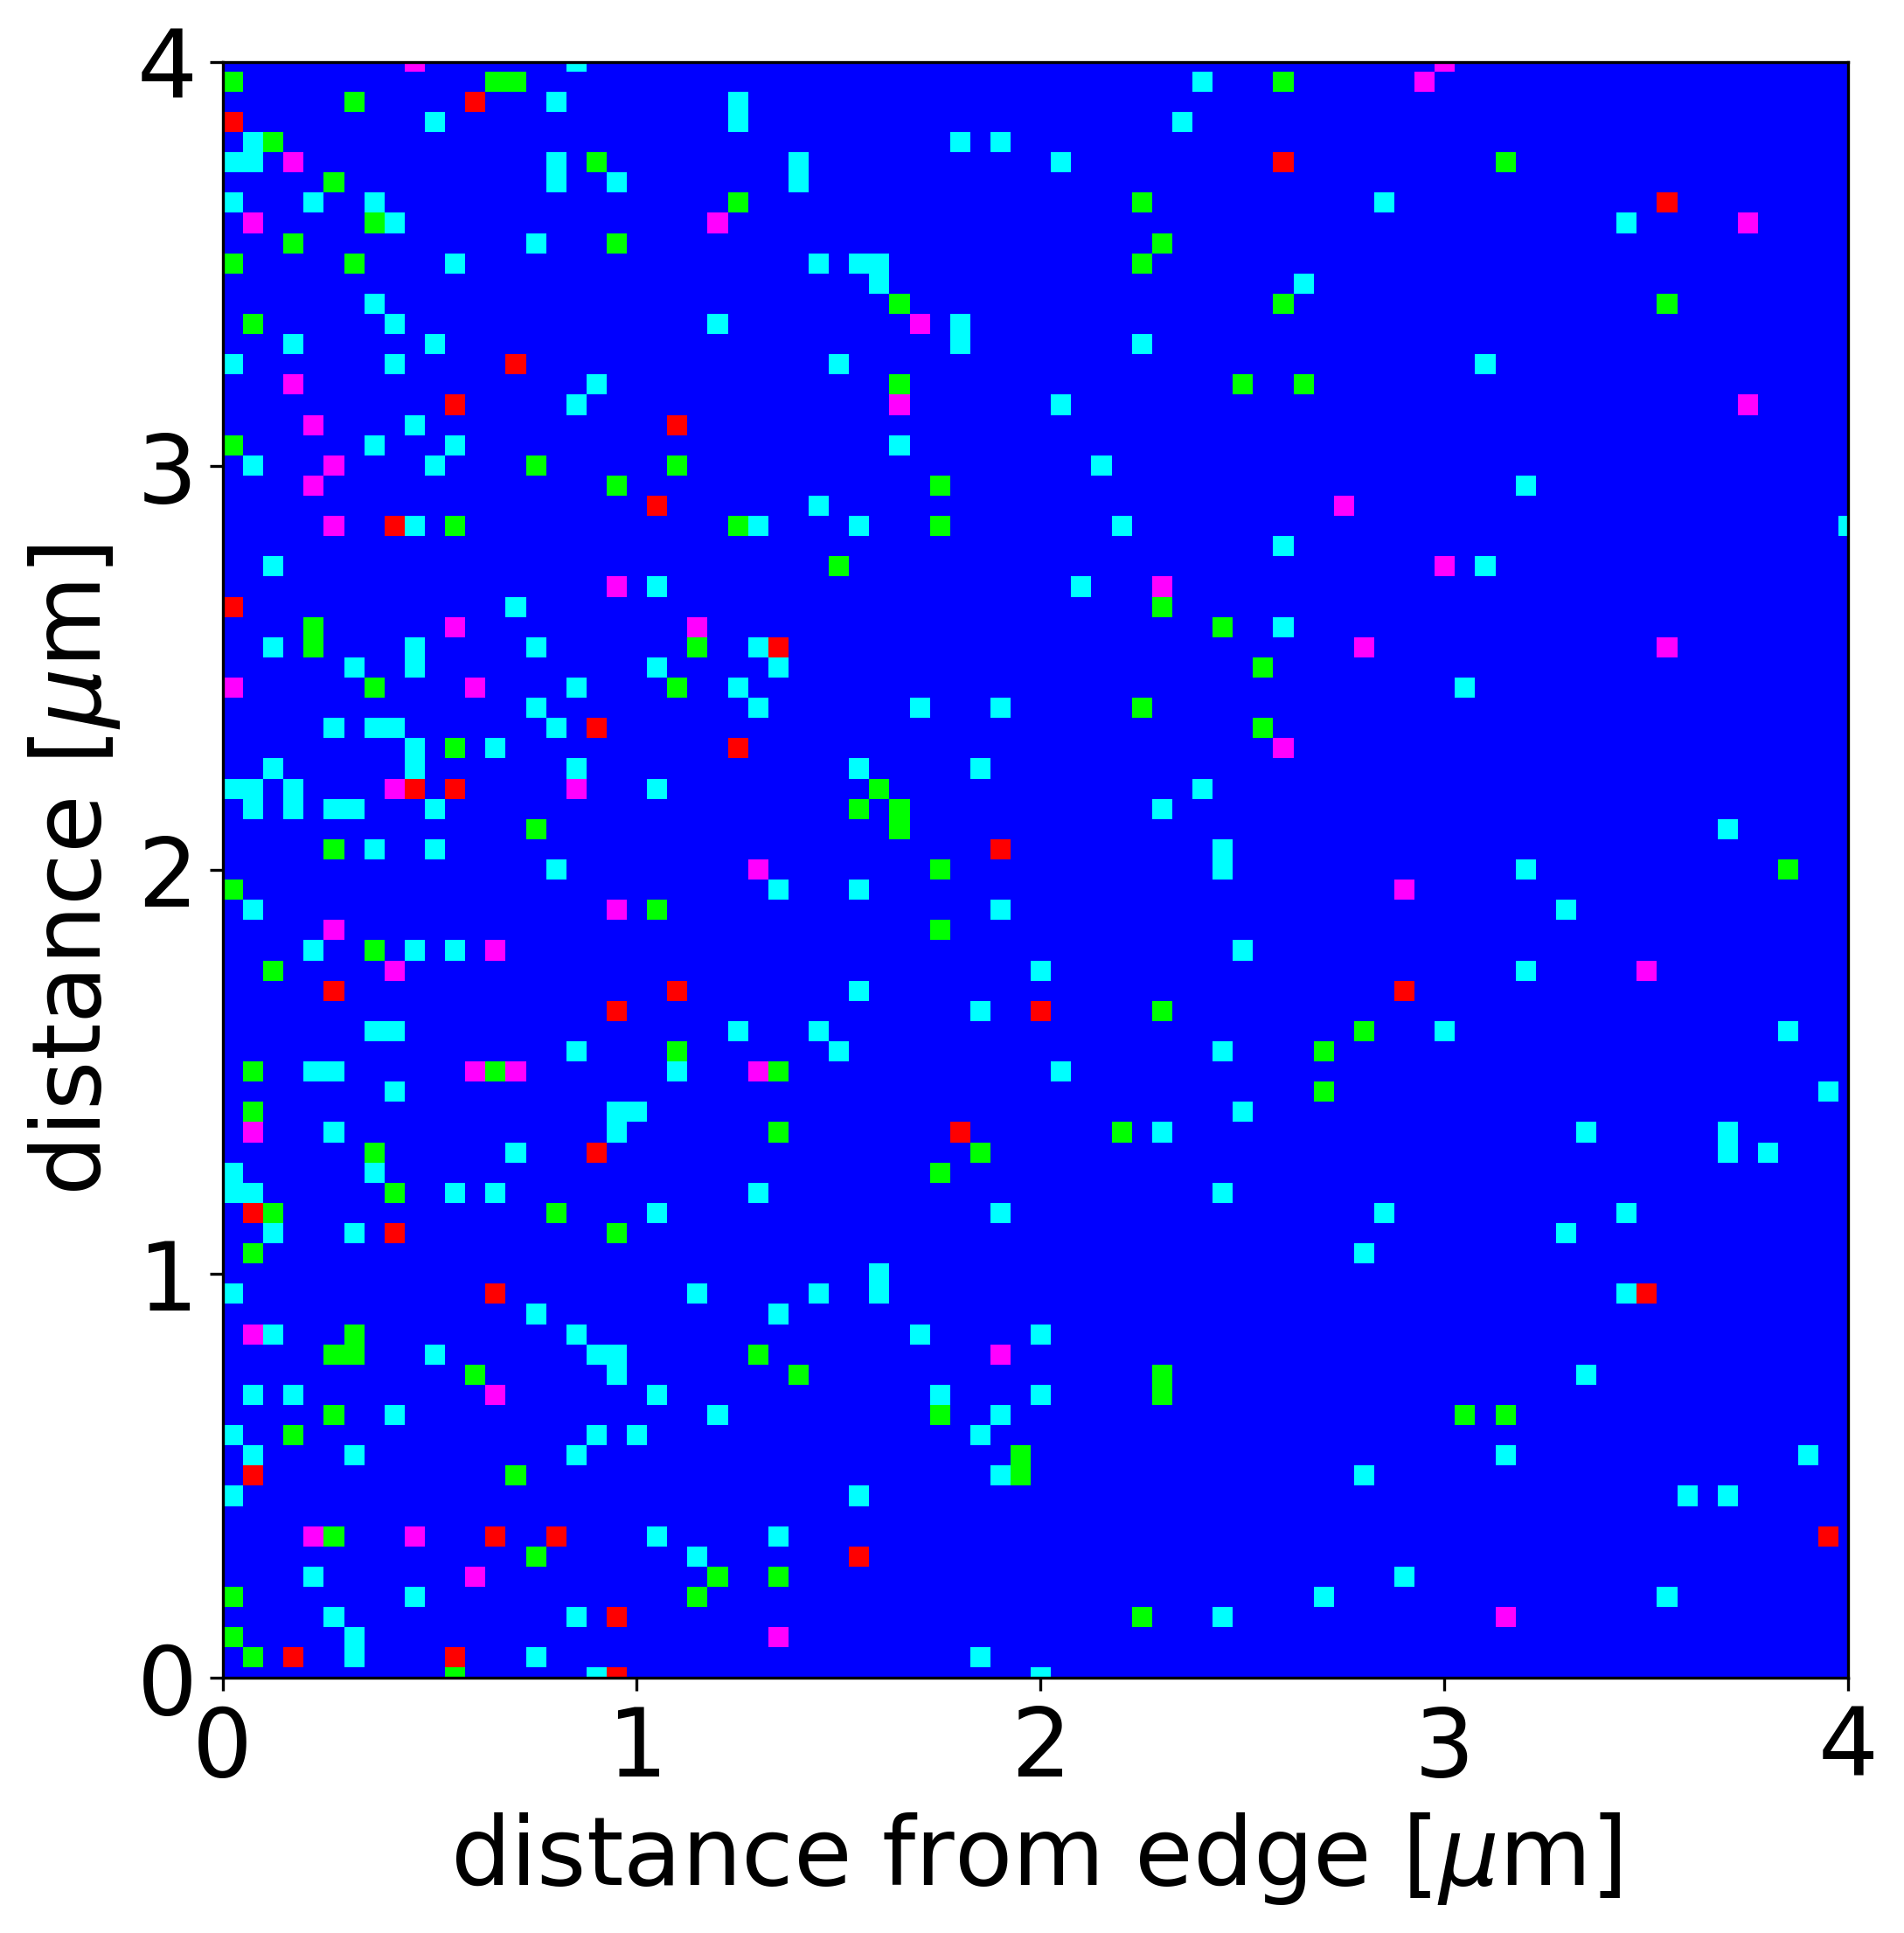

In [3]:
plt.figure(figsize=(8, 8), dpi=300)
plt.imshow(final_image[:, ::-1], origin='lower', aspect='equal')
plt.xlabel(r'distance from edge [$\mu$m]')
plt.ylabel(r'distance [$\mu$m]')
plt.ylim(0, 80)
plt.yticks([0, 20, 40, 60, 80], labels=[0, 1, 2, 3, 4])
plt.xlim(-0.5, 80)
plt.xticks([-.5, 20, 40, 60, 80], labels=[0, 1, 2, 3, 4])
plt.show()
